# Import libraries

In [42]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from PIL import Image
import matplotlib.pyplot as plt
from vit_keras import vit    #import feature extractors that will be used
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from keras_self_attention import SeqSelfAttention

In [2]:
BASE_DIR = 'flickr8k'    #or change to 'flickr30k'

# Load image features


In [3]:
#other extracted in 'Feature extraction.ipynb' features can be loaded

with open('features_vit_384.pickle', 'rb') as handle:
    features = pickle.load(handle)

# Load mapping and tokenizer

In [4]:
with open('mapping_flickr8k.pickle', 'rb') as handle:
    mapping = pickle.load(handle)
    
with open('tokenizer_flickr8k.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [5]:
#found in 'Captions processing.ipynb'

max_length = 35    #75 for Flickr30K

# Load model

In [ ]:
model = load_model('best_model_vit_384.h5')

In [ ]:
#main approach model with self-attention must be loaded in this way
model = load_model('best_model_vit_b16_384_self_attention.h5', custom_objects={'SeqSelfAttention':SeqSelfAttention})

Convert predicted index into a word

In [7]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

Caption generator that appends all words

In [8]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    in_text = in_text.replace('startseq ', '')
    in_text = in_text.replace(' endseq', '')
    return in_text

Comparison of actual and predicted captions (visualization)

In [9]:
def captions_comparison(image_name):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        caption = caption.replace('startseq ', '')
        caption = caption.replace(' endseq', '')
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
black dog is in the grass with woman in jeans
grey in grey sweashirt running alongside of small dog
person playing with their black dog in the grass
woman and dog are running in field
woman flies kite in field while her dog watches
--------------------Predicted--------------------
man training dog to throw stick


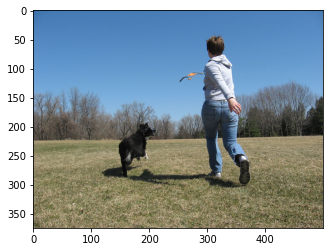

In [67]:
#VGG16
captions_comparison("460195978_fc522a4979.jpg")


---------------------Actual---------------------
black dog is in the grass with woman in jeans
grey in grey sweashirt running alongside of small dog
person playing with their black dog in the grass
woman and dog are running in field
woman flies kite in field while her dog watches
--------------------Predicted--------------------
man throwing ring for dog to fetch


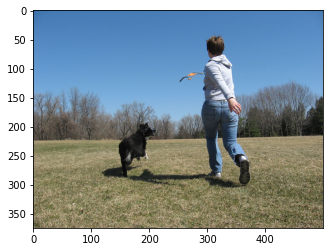

In [32]:
#ViT_B16
captions_comparison("460195978_fc522a4979.jpg")


---------------------Actual---------------------
girl makes an arc of water with her hair in pool
young girl doing back flip in the water
the girl is leaning back and splashing water with her hair
the girl is taking her hair out of the water
water streaming from young woman in swimming pool flipping her wet hair backwards
--------------------Predicted--------------------
girl in pink swimsuit is swimming in pool


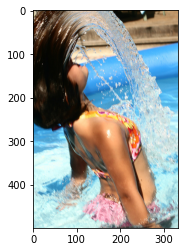

In [62]:
#VGG16
captions_comparison("755326139_ee344ece7b.jpg")


---------------------Actual---------------------
girl makes an arc of water with her hair in pool
young girl doing back flip in the water
the girl is leaning back and splashing water with her hair
the girl is taking her hair out of the water
water streaming from young woman in swimming pool flipping her wet hair backwards
--------------------Predicted--------------------
girl in watermelon swimsuit plays in water


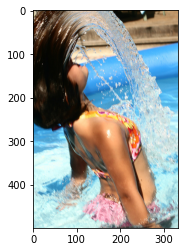

In [11]:
#ViT_B16
captions_comparison("755326139_ee344ece7b.jpg")


# Inference with an image outside of datasets
Define feature extractor

In [48]:
#CNN example

feature_extractor = VGG16() 
# restructure the model
feature_extractor = Model(inputs=feature_extractor.inputs,             
                  outputs=feature_extractor.layers[-2].output)

In [21]:
#ViT example

image_size = 384

# load vit_b16 model
feature_extractor = vit.vit_b16(image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=True)
feature_extractor = Model(inputs=feature_extractor.inputs,             
                  outputs=feature_extractor.layers[-2].output)

In [28]:
def captioning(image_path):
    # load image
    image = load_img(image_path, target_size=(384, 384))    #change according to the model
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image
    image = vit.preprocess_inputs(image)    #use image = preprocess_input(image) for CNNs
    # extract features
    feature = feature_extractor.predict(image, verbose=0)
    # predict from the trained model
    predicted = predict_caption(model, feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(predicted)
    image = Image.open(image_path)
    plt.imshow(image)

--------------------Predicted--------------------
two girls are playing in karate game


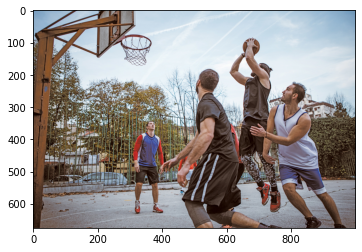

In [65]:
# VGG16
image_path = 'test2.jpg'
captioning(image_path)

--------------------Predicted--------------------
two men playing basketball


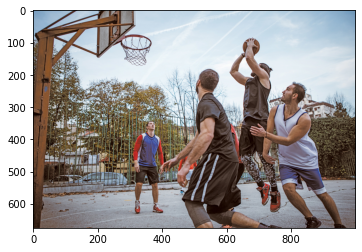

In [34]:
#ViT_B16
image_path = 'test2.jpg'
captioning(image_path)